In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import os
os.environ["TERRA_CONFIG_PATH"] = "/home/sabri/code/spr-21/terra_config.json"

import terra 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
from tqdm.auto import tqdm
from mosaic import DataPanel, NumpyArrayColumn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [46]:
from spr.data.cxr_tube import build_cxr_df, get_dp
#df = build_cxr_df()
df = build_cxr_df.out(load=True)
dp = get_dp(df)
test_dp = dp.lz[np.where(dp["split"].data == "test")[0]]

In [45]:
from spr.data.cxr_tube import CXRResnet
model = CXRResnet(
    model_path="/home/common/datasets/cxr-tube/models/best_model_target_cxr_val_accuracy.pth"
)

In [8]:
model.to(0).eval() # prepare the model for evaluation

@torch.no_grad()
def predict(batch: dict):
    probs = torch.softmax(model(batch["img"].data.to(0)), dim=-1)
    return {"probs": probs.cpu(), "pred": probs.cpu().argmax(dim=-1)}

# updated_dp has two new `TensorColumn`s: 1 for probabilities and one
# for predictions
updated_dp: DataPanel = dp.update(
    function=predict, batch_size=128, batched=True
)

In [12]:
test_dp = updated_dp.lz[np.where(dp["split"].data == "test")[0]]

In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_dp["pneumothorax"].data,  test_dp["probs"].data[:, -1])

0.8967913520933425

In [15]:
pmx_labels = test_dp["pneumothorax"].data
tube_labels = test_dp["chest_tube"].data
neg_mask = np.logical_not(pmx_labels)
postube_mask = np.logical_and(tube_labels,pmx_labels)
posnotube_mask = np.logical_and(np.logical_not(tube_labels),pmx_labels)
mask1 = np.logical_or(neg_mask,postube_mask)
mask2 = np.logical_or(neg_mask,posnotube_mask)

In [18]:
sub_dp = test_dp.lz[np.where(mask1)[0]]
roc_auc_score(sub_dp["pneumothorax"].data,  sub_dp["probs"].data[:, -1])

0.9140168342296001

In [19]:
sub_dp = test_dp.lz[np.where(mask2)[0]]
roc_auc_score(sub_dp["pneumothorax"].data,  sub_dp["probs"].data[:, -1])

0.849290780141844

In [253]:
from spr.data.cxr_tube import get_cxr_activations

#out = get_cxr_activations(dp=test_dp, model_path="/home/common/datasets/cxr-tube/models/best_model_target_cxr_val_accuracy.pth")
act_dp = get_cxr_activations.out(395, load=True)

[2021-05-18 15:43:39,722][WARNING][pip._internal.operations.freeze:72] :: Could not generate requirement for distribution -illow 8.2.0 (/home/common/envs/conda/envs/rg-sabri/lib/python3.8/site-packages): Parse error at "'-illow=='": Expected W:(abcd...)
task: get_cxr_activations, run_id=395


In [ ]:
separator = SourceSeparator(config={
    "activation_dim": 2048,
    "lr": 1e-3
}, model=model)
separator.fit(act, activation_col="activation_block4")

In [235]:
comp_dp = separator.compute(act_dp)

In [236]:
comps = comp_dp["components"].data.mean(axis=(1,2))
pd.DataFrame(comps).corr()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.950487,0.640307,-0.525435,-0.109172,0.391663,-0.458279,-0.392003,0.616136,0.943046
1,0.950487,1.000000,0.568329,-0.541171,-0.112410,0.339355,-0.400672,-0.361171,0.564944,0.945254
2,0.640307,0.568329,1.000000,-0.052790,-0.670747,0.165529,-0.880937,-0.429313,0.755568,0.675230
3,-0.525435,-0.541171,-0.052790,1.000000,0.002559,0.327343,0.005895,0.530105,0.193747,-0.512923
4,-0.109172,-0.112410,-0.670747,0.002559,1.000000,0.338899,0.842170,0.647437,-0.367034,-0.213473
5,0.391663,0.339355,0.165529,0.327343,0.338899,1.000000,0.022347,0.392812,0.528884,0.325124
6,-0.458279,-0.400672,-0.880937,0.005895,0.842170,0.022347,1.000000,0.608577,-0.671168,-0.486803
7,-0.392003,-0.361171,-0.429313,0.530105,0.647437,0.392812,0.608577,1.000000,-0.187025,-0.406088
8,0.616136,0.564944,0.755568,0.193747,-0.367034,0.528884,-0.671168,-0.187025,1.000000,0.650033
9,0.943046,0.945254,0.675230,-0.512923,-0.213473,0.325124,-0.486803,-0.406088,0.650033,1.000000


In [238]:

mask = (comp_dp["pneumothorax"] == 1)
for comp_idx in range(10):
    print(roc_auc_score(comp_dp["chest_tube"].data, comps[:, comp_idx]))

0.7792357097965878
0.7463300478767162
0.8391914608785402
0.26919795003857727
0.2855281512025385
0.4632749308930004
0.20946702024924507
0.2527195712044801
0.7176551139179708
0.8778249561853959


In [233]:
roc_auc_score(comp_dp["chest_tube"], comp_dp["pneumothorax"])

0.79580350619025

In [240]:
from spr.feedback import solicit_feedback_imgs
for comp_idx in range(comps.shape[1]):
    comp_dp.add_column(f"comp_{comp_idx}", comps[:, comp_idx], overwrite=True)

In [241]:
solicit_feedback_imgs(dp=comp_dp, label_column="chest_tube", rank_by="comp_9")

Running locally at: http://127.0.0.1:7862/
To create a public link, set `share=True` in `launch()`.
Tip: Add interpretation to your model by simply adding `interpretation="default"` to `Interface()`


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7862/', None)

In [242]:
@terra.Task.make_task
def save_feedback(label, id_col: str, run_dir=None):
    feedback_dp = comp_dp.filter(
        lambda x: x["feedback_label"] != "unlabeled",
        input_columns=["feedback_label"]
    )
    return feedback_dp[[id_col, "feedback_label", "feedback_pos_mask", "feedback_neg_mask"]].lz[:], label

In [243]:
save_feedback("chest_tube", id_col="image_id")

[2021-05-18 15:27:25,132][WARNING][pip._internal.operations.freeze:72] :: Could not generate requirement for distribution -illow 8.2.0 (/home/common/envs/conda/envs/rg-sabri/lib/python3.8/site-packages): Parse error at "'-illow=='": Expected W:(abcd...)
task: save_feedback, run_id=394


[<terra.io.Artifact at 0x7fc29e338940>, 'chest_tube']

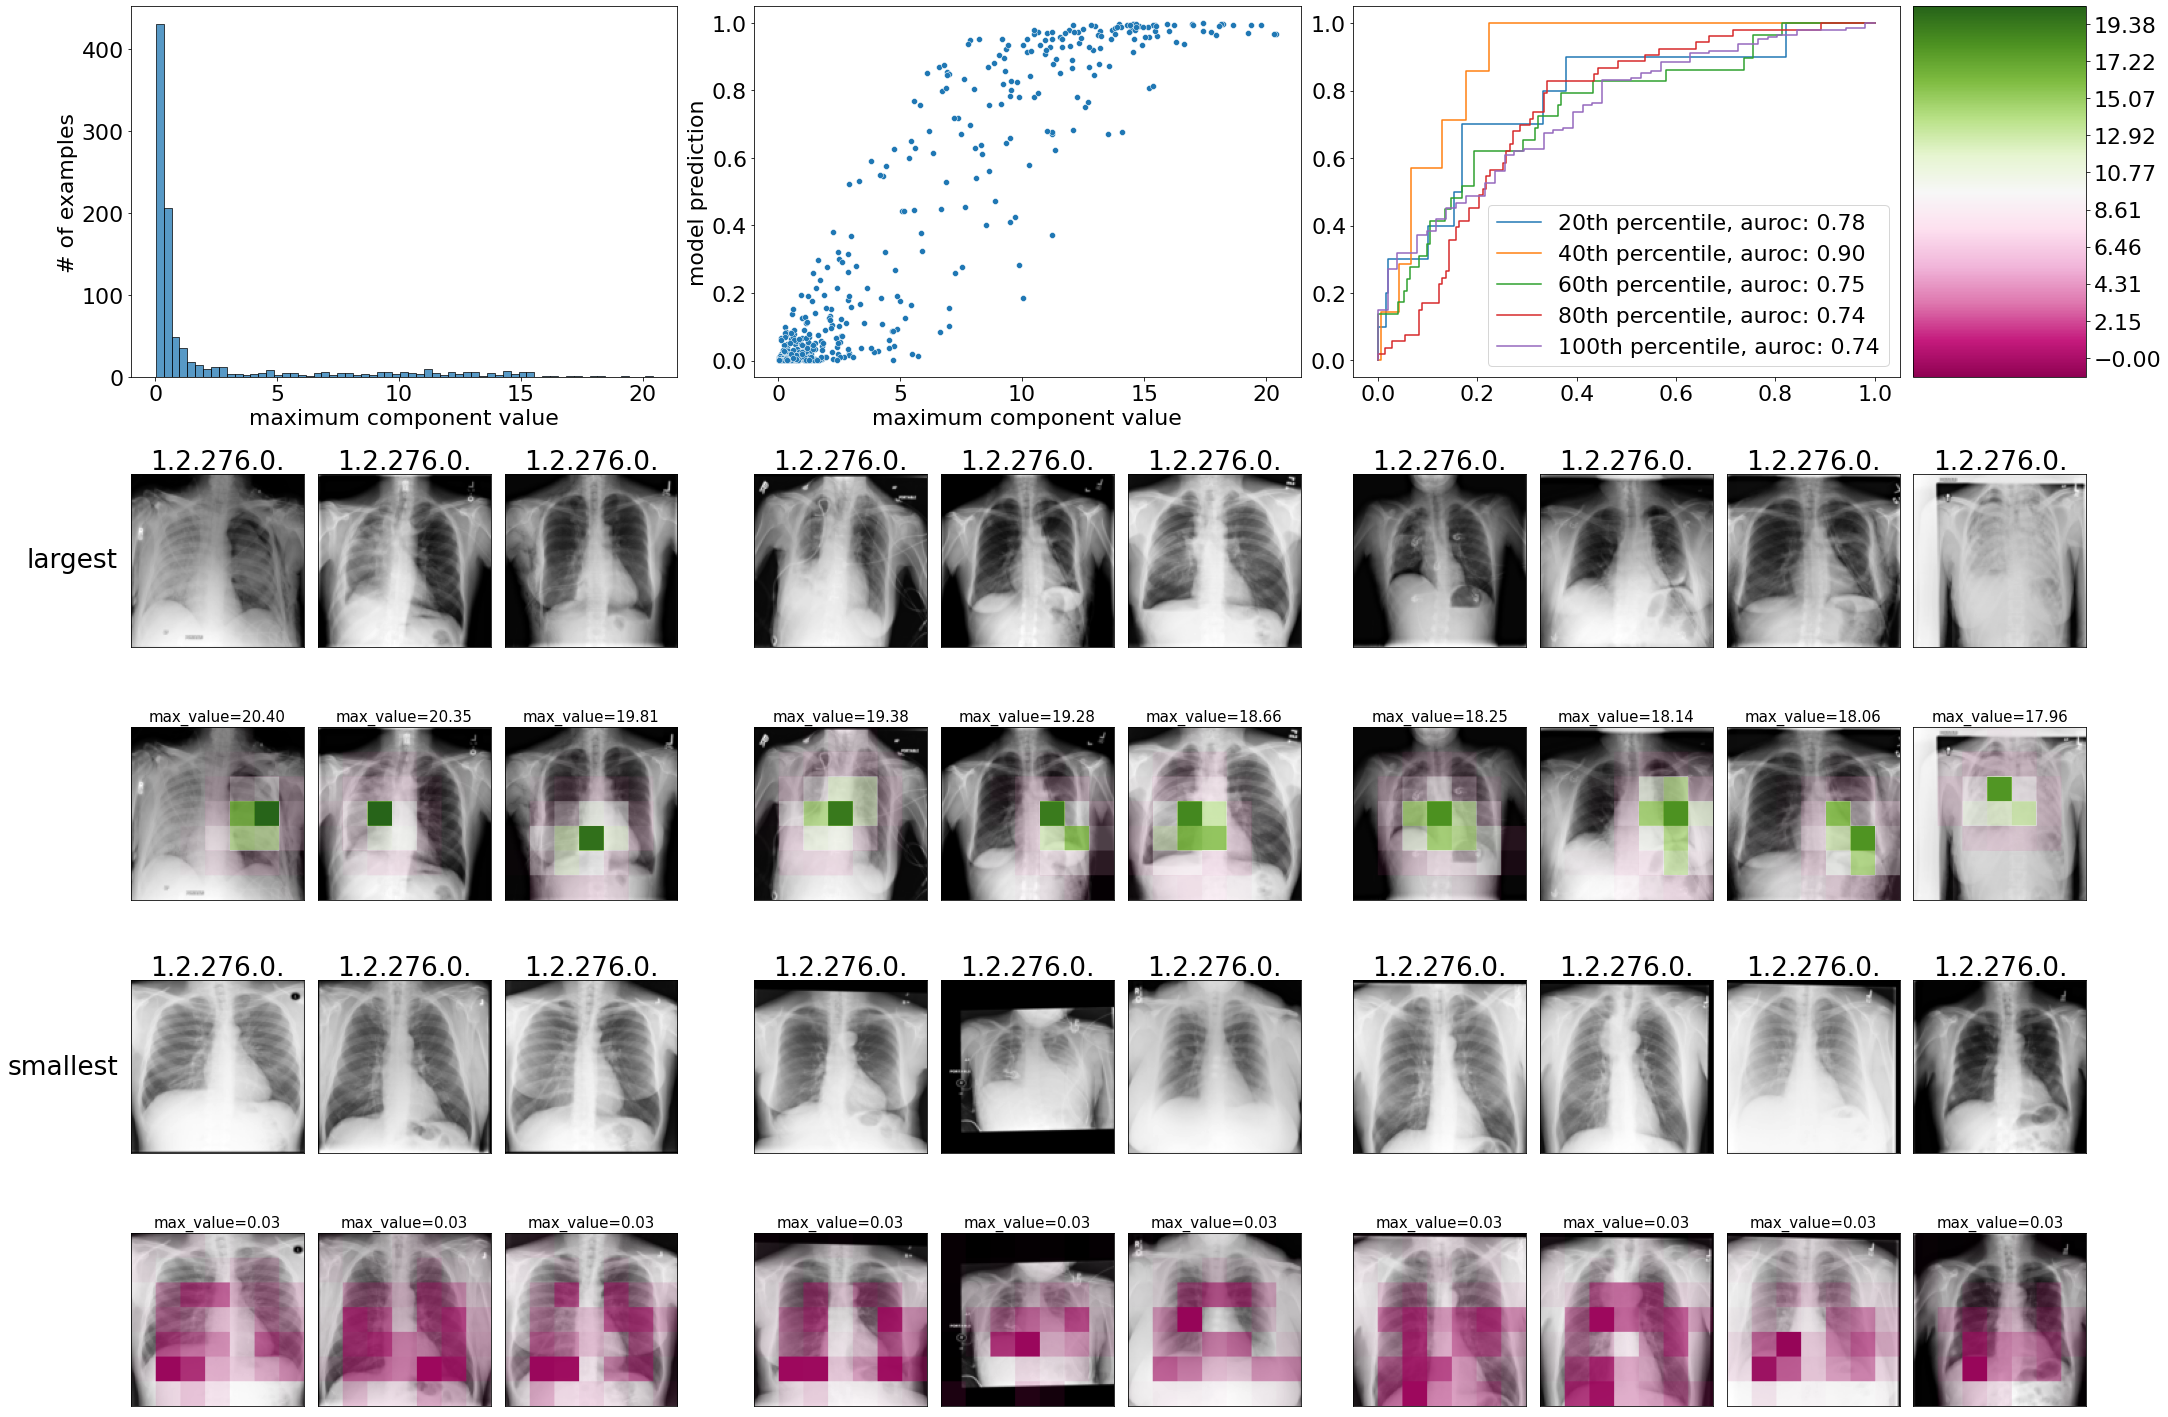

In [239]:
from spr.vis import visualize_component_dp

visualize_component_dp(
    dp=comp_dp,
    comp_idx=9,
    image_column="img",
    id_column = "image_id",
    target_column="pneumothorax",
    flipped=False
)

In [82]:
dp["img"]

,(ImageColumn)
0,MedicalVolumeCell([PosixPath('/home/common/dat...
1,MedicalVolumeCell([PosixPath('/home/common/dat...
2,MedicalVolumeCell([PosixPath('/home/common/dat...
3,MedicalVolumeCell([PosixPath('/home/common/dat...
4,MedicalVolumeCell([PosixPath('/home/common/dat...
...,...
12042,MedicalVolumeCell([PosixPath('/home/common/dat...
12043,MedicalVolumeCell([PosixPath('/home/common/dat...
12044,MedicalVolumeCell([PosixPath('/home/common/dat...
12045,MedicalVolumeCell([PosixPath('/home/common/dat...


In [108]:
comps = 
mask = (comp_dp["pneumothorax"] == 1)
roc_auc_score(comp_dp["chest_tube"].data[mask], comps[mask, 2])

0.32209457209457204

In [115]:
from spr.utils import batched_pearsonr
out = batched_pearsonr(x=torch.tensor(comps), y=torch.tensor(comps))

In [118]:
pd.DataFrame(comps).corr()

,0,1,2,3,4
0,1.000000,-0.102560,-0.102145,0.197981,-0.103898
1,-0.102560,1.000000,0.999167,-0.770037,0.999218
2,-0.102145,0.999167,1.000000,-0.770778,0.999742
3,0.197981,-0.770037,-0.770778,1.000000,-0.771782
4,-0.103898,0.999218,0.999742,-0.771782,1.000000


In [113]:
comp_dp["chest_tube"].data[comp_dp["pneumothorax"] == 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0.